## Factor Modeling a Business Cycle Indicator for Angola:
### A Dynamic Factor Modeling for Mixed-Frequencies Data

For a small, open economy, and developing economy like Angola (Southwest Africa), it is often difficult to perform macroeconomic studies, due to the unavailability of aggragate data for key indicators. For instance, GDP data for Angola is only available at the annual level, from 1990 and later years. In addition, the trend and cycle of Angola's nominal GDP follow almost perfectly the flow of international oil prices. This similarity can be explained by the fact that the Angolan economy depends almost entirely on oil revenue (over 90% of GDP). However, it is not economically feasible to proxy GDP with oil prices mainly because oil prices do not capture the real dynamics of a country's economy (even if the country depends so heavily on oil), among many other reasons.

Given this limitation in available high frequency data, I attempt to estimate an indicator of economic conditions for Angola (henceforth Economic Cycle Indicator, or ECI) with high frequency (mothly) estimates. Specifically, I do the following:

- I use the DynamicFactorMQ class from Python's Statsmodels library (https://www.statsmodels.org/). This class is build around the dynamic factor models proposed by Banbura and Modugno (2014) and Banbura et al. (2011). The choice of model is initially based on the fact that this methodology is very well documented and implementable though the python library Statsmodels, which is very convenient. Fulton (2020) is particularly a great reference for documenting a fully simulated case with the referred model, thus serving as a main guide to this exercise and a great reference for the methodology's technicalities. In addition, although the model is designed to handle big data as well as the nuances of missing data, I believe that it also better accomodates the limited amount of data available for this exercise at the moment. As a matter of fact, this model is also the foundation for the New York Fed's nowcasting report, which is detailed in Bok et al. (2018).

- I use variables proposed by Lariau et. al. (2016), given the significantly satisfactory results in the referenced research work.

- Similar to Lariau at el. (2016), the high frequency ECI data is to serve primarily as a proxy for economic conditions and Aggregate demand (it can also be understood as changes in the average growth of GDP). Although factor models of such nature are most commonly designed and used as a way to nowcast GDP (see the references section), I am reluctant to advise to use the following model results to nowcast (or forecast) GDP for Angola, given the substancial noise and structural problems in the data, the latter to be explained as I go though the process.

This exercise contains 4 main parts, namely:
1. **Data and python libraries**
2. **Model specification and Estimation**
3. **Comparison with Real GDP**
4. **Interpretation**

## 1.1 Data and python libraries

As previously mentioned, this exercise will use variables suggested in Lariau et. al. (2016), namely: exports, imports, money, and industrial production. However, the data itself is slightly different from the referenced source, contingent upon data availability. For the purposes of this exercise, the data can be defined as follows:
- Exports: value of exports, Free on Board (FOB), millions of USD, monthly (IMF)
- Imports: value of imports, Cost Insurance and Freight (CIF), millions of USD, monthly (IMF)
- Money: monetary base (currency in circulation + bank reserves), millions of AOA, monthly (BNA and IMF)
- Industrial production index: Industrial Production Index (2010 = 100), quarterly (Angola Open Data Portal and IMF)

All the data is seasonaly adjusted and in real terms (CPI deflated, as suggested in lariau et. al. 2016). Different from Lariau et al, the seasonal adjustment for this process was performed using X13 ARIMA seats, as opposed to X12.

The target modeling is performed using the DynamicFactorMQ() function from Statsmodels. Key supplemental python packages for the estimation process are equally listed below.

In [1183]:
# Packages needed

%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

In [1184]:
#Import the data
#Monthly data
m_variables = ['Rexp', 'Rimp', 'Rm0', 'Rpcr']
mdata = pd.read_excel("Desktop/ECI_seas_adj.xlsx", 
                         sheet_name = 'monthly', parse_dates = [0]).set_index('Date')
mdata.index = [str(pd.Timestamp(x))[:7] for x in list(mdata.index)]
mdata = mdata[m_variables]

#Quarterly data
q_variables = ['R_ip']
qdata = pd.read_excel("Desktop/ECI_seas_adj.xlsx", 
                         sheet_name = 'quarterly', parse_dates = [0]).set_index('Date')
qdata.index = [str(pd.Timestamp(x))[:7] for x in list(qdata.index)]
qdata = qdata[q_variables]

## 1.2 Data transformations

In building dynamic factor models, it is often convention to use stationary and standardized data. Since standardization process is already built into the DynamicFactorMQ() model, I only do the data transformation necessary for stationarity. For this simulation, I use conventions proposed in the Fred-MD and FRED-QD databases (https://research.stlouisfed.org/econ/mccracken/fred-databases/). The logarithmic and differencing transformations, along with basic plots of the data are presented in the following cells.

In [1185]:
# Data transformations: Create Log differenced series
# Monthly data: approximate percent change
mdata['dln_exp'] = (np.log(mdata.Rexp)).diff()*100
mdata['dln_imp'] = (np.log(mdata.Rimp)).diff()*100
mdata['dln_m0'] = (np.log(mdata.Rm0)).diff()*100
mdata['dln_pcr'] = (np.log(mdata.Rpcr)).diff()*100

#Quarterly data: annualized approximate percent change
qdata['dln_ip'] = (np.log(qdata.R_ip)).diff()*400

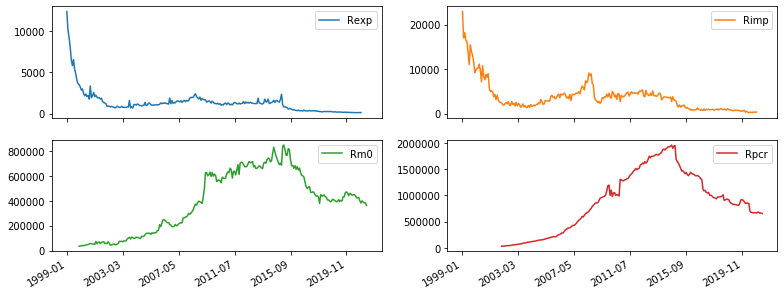

In [1186]:
#Normal data plots
mdata.loc[:, 'Rexp':'Rpcr'].plot(subplots = True, layout=(2, 2), figsize = (13,5));

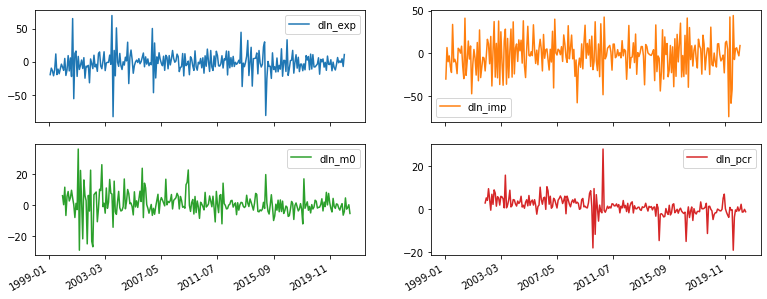

In [1187]:
#Differenced data plots
mdata.loc[:, 'dln_exp':'dln_pcr'].plot(subplots = True, layout =(2,2), figsize = (13,5));

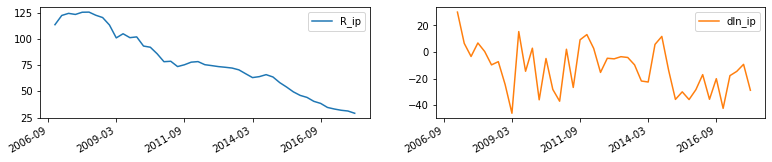

In [1188]:
qdata.plot(subplots = True, layout=(2,2), figsize = (13,5));

Note that it is also possible to identify some outliers from the differenced data plots above. However, I will not remove them due to the limited amount of data and potentially oversmoothing the final estimates, since the Angola's economy is significantly volatile at current times.

## 2.1 Model specification and estimation

In the lines of code that follow, the quarterly and monthly data are merged into a single dataset, so that empty values can be properly created (a common feature of dynamic factor models), and the model is subsequently estimated. Refer to Fulton (2020) for a second scheme where datasets are loaded into the model separately.

In [1189]:
#Construct single dataset that joins monthly data and quarterly data
start = qdata.index[2]
df = pd.concat([mdata.loc[:, 'dln_exp':'dln_pcr'], qdata['dln_ip']],axis=1,join='outer')
df.index = pd.DatetimeIndex(df.index).to_period('M')
df.sort_index(inplace=True)
df = df.loc[start:]

#df.head()

In [1190]:
#Model specification (single dataset; 1 factor; no multiplicities; factor order = 3 )
factor = {col : ['Factor'] for col in df} # allows all the variables to load into a single globas factor
monthly_varbs = 4 # number of monthly variables in the model
AR_process = 1 # lag order of the AR process behind the dynamic factor

#Define endog dataset
endog = df.loc['2007-01':'2020-12',]

#Build model
mod = sm.tsa.DynamicFactorMQ(endog, k_endog_monthly= monthly_varbs, factors = factor, factor_orders = AR_process)

In [1191]:
# Model summary
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Model Specification: Dynamic Factor Model                         
===========================================================================================
Model:                Dynamic Factor Model   # of monthly variables:                      4
                   + 1 factors in 1 blocks   # of quarterly variables:                    1
                   + Mixed frequency (M/Q)   # of factors:                                1
                     + AR(1) idiosyncratic   Idiosyncratic disturbances:              AR(1)
Sample:                            2007-01   Standardize variables:                    True
                                 - 2020-12                                                 
Observed variables / factor loadings
========================
Dep. variable     Factor
------------------------
      dln_exp       X   
      dln_imp       X   
       dln_m0       X   
      dln_pcr       X   
       dln_ip       X   
    Factor blocks:   
=====================
     block      order
---------------------
    Factor          1
=====================
"""

In [1192]:
#Model fitting
result = mod.fit(disp = 10)

EM start iterations, llf=-1021.2
EM iteration 10, llf=-979.04, convergence criterion=0.00023517
EM iteration 20, llf=-978.23, convergence criterion=3.8897e-05
EM iteration 30, llf=-977.96, convergence criterion=2.2264e-05
EM iteration 40, llf=-977.77, convergence criterion=1.5763e-05
EM iteration 50, llf=-977.65, convergence criterion=1.0796e-05
EM iteration 60, llf=-977.56, convergence criterion=7.2773e-06
EM iteration 70, llf=-977.5, convergence criterion=4.9756e-06
EM iteration 80, llf=-977.46, convergence criterion=3.5082e-06
EM iteration 90, llf=-977.44, convergence criterion=2.5719e-06
EM iteration 100, llf=-977.41, convergence criterion=1.9682e-06
EM iteration 110, llf=-977.4, convergence criterion=1.5743e-06
EM iteration 120, llf=-977.38, convergence criterion=1.3155e-06
EM iteration 130, llf=-977.37, convergence criterion=1.1457e-06
EM iteration 140, llf=-977.36, convergence criterion=1.0362e-06
EM converged at iteration 145, llf=-977.36, convergence criterion=9.9809e-07 < tol

In [1193]:
#Results summary
result.summary(display_diagnostics = True)

Dep. Variable:,"""dln_exp"", and 4 more",No. Observations:,168
Model:,Dynamic Factor Model,Log Likelihood,-977.355
,+ 1 factors in 1 blocks,AIC,1988.709
,+ Mixed frequency (M/Q),BIC,2041.817
,+ AR(1) idiosyncratic,HQIC,2010.263
Date:,"Tue, 13 Jul 2021",EM Iterations,145
Time:,22:56:34,,
Sample:,01-31-2007,,
,- 12-31-2020,,
Covariance Type:,Not computed,,
Factor loadings:,Factor,idiosyncratic: AR(1),var.


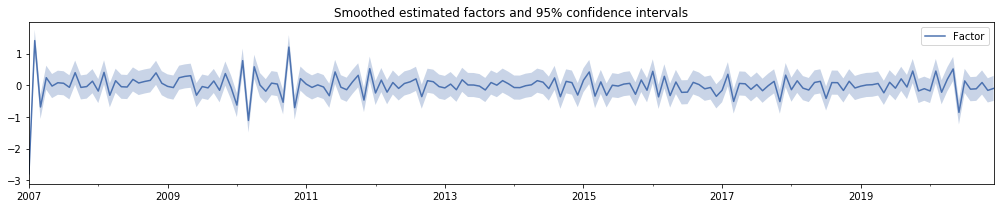

In [1194]:
# Get estimates of the smoothed factor, and plot them
factor_name = ['Factor']
mean = result.factors.smoothed[factor_name]
std = pd.concat([result.factors.smoothed_cov.loc[name]
                for name in factor_name], axis = 1)

from scipy.stats import norm
crit = norm.ppf(1-0.05/2)
lower = mean - crit * std
upper = mean + crit * std

# A plot of the factors
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14,3))
    mean.plot(ax=ax)
    
    for name in factor_name:
        ax.fill_between(mean.index, lower[name], upper[name], alpha = 0.3)
    
    ax.set(title = 'Smoothed estimated factors and 95% confidence intervals')
    fig.tight_layout()

## 2.2 Goodness of fit
The plot above shows the smoothed (conditional upon entire dataset) factor. This factor represents the common element or pattern among the chosen variables. One way to understand the factor's relationship to its endogenous variables is to compute the coefficient of determination (R^2). In regression analysis, R^2 (R-square) indicates the goodness of fit or explanatory power of the model estimates in relationship to the dependent variable. In this case, the R-square will show how well the [common] dynamic factor explains each of its endogenous variables.

In [1197]:
# Computing/extracting R-square
rsquared = result.get_coefficients_of_determination(method = 'individual')

#rsquared

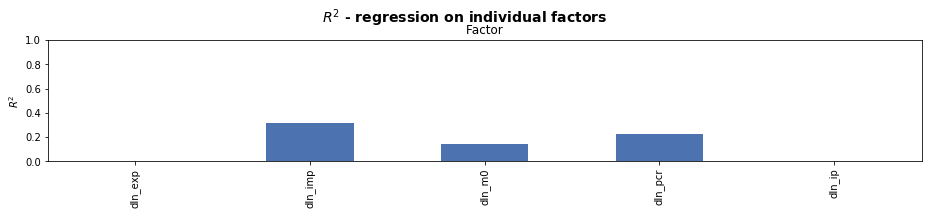

In [1198]:
#Plotting R-square
with sns.color_palette('deep'):
    fig = result.plot_coefficients_of_determination(method='individual', figsize=(13, 3))
    fig.suptitle(r'$R^2$ - regression on individual factors', fontsize=14, fontweight=600)
    fig.tight_layout(rect=[0, 0, 1, 0.95]);
    
# THE ESTIMATED GLOBAL FACTOR HAS VERY LOW EXPLANATORY POWER OVER THE OBSERVED VARIABLES.
# HOW TO IMPROVE THE FACTOR ESTIMATE?
# A POTENTIAL SOLUTION MIGHT BE TO GET MORE DATA FOR CURRENT VARIABLES, AS WELL AS ADD NEW VARIABLES

As see in the graph and table above, the estimated factor has siginificantly low explanatory power over the endogenous variables. This deficiency can be traced into a number of key causes, among them poor-quality data, small sample size, and limited availability of data on procyclical variables. This is also sufficient evidence for a need to improve future iterations of the ECI estimation process for Angola.

## 3. ECI comparison with Annual GDP

Some of the great uses of Dynamic factor models similar to the technique applied in this exercise include forecasting and nowcasting. However, none of the former functions is addressed in this notebook, because the focus for this exercise is to look at the dynamic factor estimates in hindsight. In other words, we are primarily interested in the past observations of the common factors, which can then serve as a proxy for a high frequency economic conditions indicator such as GDP (which is often observed only at quarterly and yearly frequency).

Thus, I now turn to analyzing the movements of the estimated ECI in comparison to the annual GDP. This exercise is limited to a graphical comparison. However, a direct computation of errors or deviations are a good alternative as well. 

In [1199]:
# Importing Annual GDP data
y_variable = ['RGDP']
ydata = pd.read_csv("Desktop/eci_ydata.csv", parse_dates = [0]).set_index('Year')
ydata.index = [str(pd.Timestamp(x))[:7] for x in list(ydata.index)]
Rgdp = ydata[y_variable]
#Rgdp

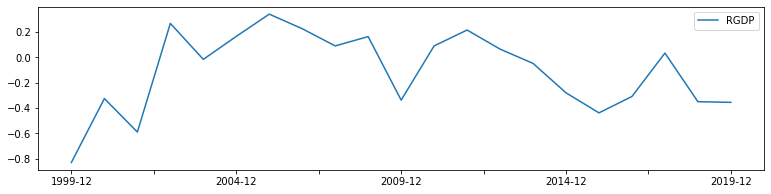

In [1200]:
# GDP Data transformation: annual growth rate
dln_rgdp = (np.log(Rgdp)).diff()
dln_rgdp = dln_rgdp.dropna()
dln_rgdp.plot(figsize = (13,3))
#dln_rgdp

Note that, as an alternative to differencing, we can also extract the ciclycal component of GDP directly. This alternative task can be computed using the HP filter (see https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter), which is also well documented into the Statsmodels package. The code below accomplished this alternative.

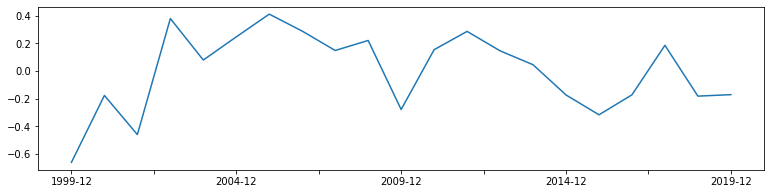

In [1201]:
# GDP cycle estimation
rgdp_cycle, rgdp_trend = sm.tsa.filters.hpfilter(dln_rgdp)
rgdp_cycle.plot(figsize = (13,3))

The following code plots both the cyclical component of real GDP along with the estimated ECI (as a proxy for business cycles or aggregate demand). 

In [1202]:
# Data filtering and storage
df['eci_factor'] = mean

dec_data = df[df.index.month == 12]

yfactor = dec_data.loc['2007':'2019','eci_factor':]

yrgdp = dln_rgdp.loc['2007':,]
yrgdp.index = pd.DatetimeIndex(yrgdp.index).to_period('M')
yrgdp.sort_index(inplace=True)

crgdp = rgdp_cycle.loc['2007':,]
crgdp.index = pd.DatetimeIndex(crgdp.index).to_period('M')
crgdp.sort_index(inplace=True)

merged_data = yfactor.merge(crgdp, how = 'outer', left_index = True, right_index = True)
#merged_data = merged_data.merge(yrgdp, how = 'outer', left_index = True, right_index = True)
new_names = ['ECI_factor', 'GDP_cycle']
merged_data.columns = new_names
#merged_data

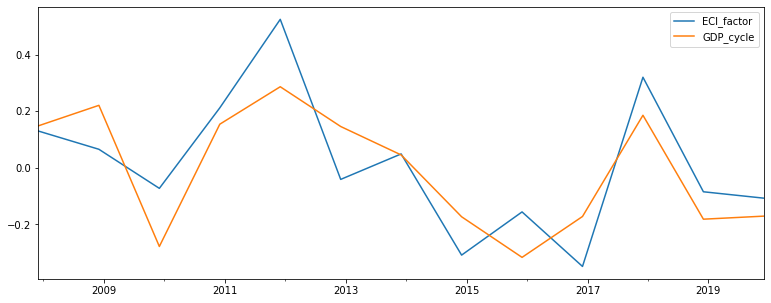

In [1203]:
merged_data.loc[:,:'GDP_cycle'].plot(figsize = (13,5))

## 4. Interpretation

Business cycle indicators similar to the exercise above tend to be interpreted as growth above or below average.
The graph above captures 12 years of GDP fluctuation in Angola. The standardization processess inherent from the model allows for an interpretation of the zero value as an average. Deviations from zero thus represent growth above average or the below average. In that sense, the ECI coincides with the cyclical portion of GDP in Angola, showing a significant decline in real GDP growth between the periods of 2014 to 2017, most of which signals the economic crisis started in Angola in the same time period, mostly due to the radical drop in international oil prices.

Thus, despite the noise, the ECI can potentially serve as a proxy for the GDP cycle with higher frequency data (in this case, monthly). However, the economic and statistical signicance of this indicator can only be fully observed or analyzed in an empirical research project, which is left here as a suggestion for future research and subsequent improvements in the estimation of this indicator.

## References

Arouba, S; Diebold, F; Scotti, C. (2008). Real-Time Measurement of Business Conditions. https://www.philadelphiafed.org/-/media/frbp/assets/surveys-and-data/ads/real-time-measurement-of-business-conditions14.pdf?la=en&hash=8CB33CA37D2F88A57F3622F4060D2CD5

Arouba, S; Diebold, F; Kose, M; Terrones, M. (2011). Globalization, the Business Cycle, and Macroeconomic Monitoring. https://www.jstor.org/stable/10.1086/658307?seq=1#metadata_info_tab_contents

Banbura, M; Modugno, M. (2014). Maximum Likelihood Estimation of Factor Models and Datasets With Arbitrary Pattern of Missing Data. Journal of Applied Econometrics. https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.2306

Banbura, M; Giannone, D; Reichlin, L. (2011). Nowcasting. The Oxford Handbook of Economic Forecasting. https://www.oxfordhandbooks.com/view/10.1093/oxfordhb/9780195398649.001.0001/oxfordhb-9780195398649-e-8

Bok, B; Caratelli, D; Giannone, D; Sbordone, A; Tambalotti, A. (2018). Macroeconomic Nowcasting and Forecasting with Big Data. Federal Reserve Bank of New York. https://www.newyorkfed.org/research/staff_reports/sr830

Durbin, J; Koopman, S. (2012). TIme Series Analysis by State Space Models: Second Edition. Oxford Statistical Science Series, 38

Fulton, C. (2020). Large dynamic factor models, forecasting, and nowcasting. http://www.chadfulton.com/topics/statespace_large_dynamic_factor_models.html

Lariau, A; Said, M; Takebe, M. (2016). As Assessment of the Exchange Rate Pass-Through in Angola and Nigeria. IMF Working Paper. https://www.imf.org/en/Publications/WP/Issues/2016/12/31/An-Assessment-of-the-Exchange-Rate-Pass-Through-in-Angola-and-Nigeria-44281

Mariano, R; Murasawa, Y. (2010). A coincident Index, Common Factors, and Monthly Real GDP. oxford Bulleting of Economics and Statistics, 71, 1. https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1468-0084.2009.00567.x

Stock, J; Watson, M. (1989). New Indexes of Coincident and Leading Economic Indicators. NBER Macroeconomics Annual 1989, Volume 4. MIT Press. https://www.nber.org/books-and-chapters/nber-macroeconomics-annual-1989-volume-4/new-indexes-coincident-and-leading-economic-indicators

Yip, J. (2020) Macroeconomic Nowcasting With Kalman Filtering. https://towardsdatascience.com/macroeconomic-nowcasting-with-kalman-filtering-557926dbc737
